# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Análise e Previsão de Séries Temporais com Inteligência Artificial</font>

## <font color='blue'>Estudo de Caso 1</font>
### <font color='blue'>Previsão de Demanda de Produtos ao Longo do Tempo Para Otimizar Decisões de Logística</font>
### <font color='blue'>Parte 3 - XGBoost</font>

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
!pip install -q xgboost

In [4]:
# Imports
import holidays
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

numpy      : 1.21.5
matplotlib : 3.5.2
statsmodels: 0.13.2
holidays   : 0.17.2
xgboost    : 1.7.2
pandas     : 1.4.4



## Carregando os Dados

In [6]:
dados = pd.read_csv('dados/dataset.csv')

In [7]:
dados.shape

(913000, 4)

In [8]:
dados.head()

,data,loja,produto,itens_vendidos
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [9]:
# Filtro pela loja
amostra = dados[dados['loja'] == 1]

In [10]:
# Filtro pelo produto
amostra = amostra[amostra['produto'] == 1]

## Engenharia de Atributos

Os atributos no dataset original não são suficientes para treinar um modelo poderoso como XGBoost. Serão necessários outros atributos, os quais iremos providenciar agora.

Vamos gerar recursos adicionais para fornecer mais informações para o algoritmo de aprendizado de máquina:

* Atributos Date Time
* Atributos Lag/Shifted
* Atributos Rolling Window
* Atributos Exponentially Weight Mean (EWM)

### Atributos Date Time

Podemos usar o registro de data e hora e gerar um recurso chamado *is_holiday*, que informa se um dia é feriado ou não. Além disso podemos transformar a data e hora em diversas outras variáveis de data.

In [11]:
# Função para listar feriados
def lista_holidays(df):
    
    df['data'] = pd.to_datetime(df.data)
    
    min_year = df.data.min().year
    max_year = df.data.max().year
    
    years_list = pd.period_range(min_year, max_year, freq = 'Y')
    
    list_of_holidays = []
    
    for year in years_list:
        list_of_holidays.append(holidays.US(years = int(str(year))).keys())
        
    holiday_list = [item for sublist in list_of_holidays for item in sublist]
    
    return holiday_list

In [12]:
# Função para criar os novos atributos date e time
def cria_atributos_date_time(df):
    
    df['data'] = pd.to_datetime(df.data)
    df['month'] = df.data.dt.month
    df['day_of_month'] = df.data.dt.day
    df['day_of_year'] = df.data.dt.dayofyear
    df['week_of_year'] = df.data.dt.weekofyear
    df['day_of_week'] = df.data.dt.weekday + 1
    df['year'] = df.data.dt.year 
    df['is_weekend'] = df.data.dt.weekday // 5
    df['start_of_month'] = df.data.dt.is_month_start.astype(int)
    df['end_of_month'] = df.data.dt.is_month_end.astype(int)
    df['is_holiday'] = np.where(df.data.isin(lista_holidays(df)), 1, 0)
    
    return df

In [13]:
# Aplica a função
df = cria_atributos_date_time(dados)

In [14]:
df.shape

(913000, 14)

In [15]:
df.head()

,data,loja,produto,itens_vendidos,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_weekend,start_of_month,end_of_month,is_holiday
0,2013-01-01,1,1,13,1,1,1,1,2,2013,0,1,0,1
1,2013-01-02,1,1,11,1,2,2,1,3,2013,0,0,0,0
2,2013-01-03,1,1,14,1,3,3,1,4,2013,0,0,0,0
3,2013-01-04,1,1,13,1,4,4,1,5,2013,0,0,0,0
4,2013-01-05,1,1,10,1,5,5,1,6,2013,1,0,0,0


In [16]:
# Define a coluna de data como índice
df = df.set_index('data')

In [17]:
df.shape

(913000, 13)

In [18]:
df.head()

,loja,produto,itens_vendidos,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_weekend,start_of_month,end_of_month,is_holiday
data,,,,,,,,,,,,,
2013-01-01,1,1,13,1,1,1,1,2,2013,0,1,0,1
2013-01-02,1,1,11,1,2,2,1,3,2013,0,0,0,0
2013-01-03,1,1,14,1,3,3,1,4,2013,0,0,0,0
2013-01-04,1,1,13,1,4,4,1,5,2013,0,0,0,0
2013-01-05,1,1,10,1,5,5,1,6,2013,1,0,0,0


### Atributos Lag/Shifted

Os recursos de atraso são úteis porque o valor observado no tempo $t$ é altamente dependente do valor observado no tempo $t-1$

Estamos dizendo ao modelo para olhar para o passado quantos dias especificarmos e usar o valor de vendas no passado como um novo recurso.

In [19]:
# Lista de lags
lag_list = [91, 92, 93, 94, 95, 96, 97, 98, 100, 105, 112, 119, 126, 150,
            182, 200, 220, 250, 300, 350, 355, 360, 361, 362, 363, 364,
            365, 370, 375, 380, 546, 600, 650, 680, 690, 700, 710, 728,
            730, 800, 900, 950, 990, 1000, 1050, 1090, 1095]

In [20]:
# Função
def cria_atributos_lag(df, lag_list):
    for lag in lag_list:
        df['lag' + str(lag)] = df.groupby(["loja", "produto"]).itens_vendidos.shift(lag)
    return df

In [21]:
df = cria_atributos_lag(df, lag_list)

In [22]:
df.shape

(913000, 60)

In [23]:
df.head()

,loja,produto,itens_vendidos,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_weekend,...,lag728,lag730,lag800,lag900,lag950,lag990,lag1000,lag1050,lag1090,lag1095
data,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,13,1,1,1,1,2,2013,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,1,1,11,1,2,2,1,3,2013,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,1,1,14,1,3,3,1,4,2013,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,1,1,13,1,4,4,1,5,2013,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,1,1,10,1,5,5,1,6,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Existem muitos valores NaN no início do conjunto de dados. Isso ocorre porque movemos os dados no tempo.

### Atributos Rolling Window

Com a média móvel inserimos uma janela de tempo e calculamos a média ou a demanda média desse período de tempo.

In [24]:
# Lista de janelas
windows_list = [91, 98, 105, 112, 119, 126, 186, 200, 210, 250, 300, 365, 546, 700]

In [25]:
# Função
def cria_atributo_rolling_mean(df, windows_list):
    for window in windows_list:
        df['vendas_rolling_mean' + str(window)] = df.groupby(["loja", "produto"]).itens_vendidos.rolling(window).mean().shift(1).values
    return df

In [26]:
df = cria_atributo_rolling_mean(df, windows_list)

In [27]:
df.shape

(913000, 74)

In [28]:
df.head()

,loja,produto,itens_vendidos,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_weekend,...,vendas_rolling_mean119,vendas_rolling_mean126,vendas_rolling_mean186,vendas_rolling_mean200,vendas_rolling_mean210,vendas_rolling_mean250,vendas_rolling_mean300,vendas_rolling_mean365,vendas_rolling_mean546,vendas_rolling_mean700
data,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,13,1,1,1,1,2,2013,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,1,1,11,1,2,2,1,3,2013,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,1,1,14,1,3,3,1,4,2013,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,1,1,13,1,4,4,1,5,2013,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,1,1,10,1,5,5,1,6,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Atributos Exponentially Weight Mean (EWM)

Esse recurso aplica peso aos valores da série temporal. Valores mais recentes terão um peso maior aplicado a eles. Isso porque os pontos mais recentes serão mais relevantes para as previsões futuras.

In [29]:
# Lags
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

In [30]:
# Lista de alfas
alpha_list = [0.95, 0.9, 0.8, 0.7, 0.5]

In [31]:
# Função
def cria_atributos_ewm(df, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            df['sales_ewm_alpha_' + str(alpha).replace(".","") + 
              "_lag_" + str(lag)] = df.groupby(["loja", "produto"]).itens_vendidos.transform(
            lambda x: x.shift(lag).ewm(alpha = alpha).mean())
    return df

In [32]:
df = cria_atributos_ewm(df, alpha_list, lags)

In [33]:
df.shape

(913000, 119)

In [34]:
df.head()

,loja,produto,itens_vendidos,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_weekend,...,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
data,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,13,1,1,1,1,2,2013,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,1,1,11,1,2,2,1,3,2013,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,1,1,14,1,3,3,1,4,2013,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,1,1,13,1,4,4,1,5,2013,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,1,1,10,1,5,5,1,6,2013,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# Converte variáveis categóricas em variáveis dummy aplicando One-Hot Encoding
df = pd.get_dummies(df, columns = ['loja', 'produto', 'day_of_week', 'month'])

In [36]:
df.shape

(913000, 194)

In [37]:
df.head()

,itens_vendidos,day_of_month,day_of_year,week_of_year,year,is_weekend,start_of_month,end_of_month,is_holiday,lag91,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
data,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,1,1,1,2013,0,1,0,1,NaN,...,0,0,0,0,0,0,0,0,0,0
2013-01-02,11,2,2,1,2013,0,0,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
2013-01-03,14,3,3,1,2013,0,0,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
2013-01-04,13,4,4,1,2013,0,0,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
2013-01-05,10,5,5,1,2013,1,0,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0


## Preparação dos Dados

In [38]:
# Coloca os dados da variável alvo na mesma escala
df['itens_vendidos'] = np.log1p(df["itens_vendidos"].values)

In [39]:
# Colunas sem informações úteis ou com informações já derivadas serão descartadas.
cols = [col for col in df.columns if col not in ['data', 'id', "itens_vendidos", "year"]]

In [40]:
# Separa X e Y
X = df[cols]
Y = df['itens_vendidos']

In [41]:
X.shape

(913000, 192)

In [42]:
X.head()

,day_of_month,day_of_year,week_of_year,is_weekend,start_of_month,end_of_month,is_holiday,lag91,lag92,lag93,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
data,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,1,0,1,0,1,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2013-01-02,2,2,1,0,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2013-01-03,3,3,1,0,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2013-01-04,4,4,1,0,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2013-01-05,5,5,1,1,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [43]:
Y.shape

(913000,)

In [44]:
Y.head()

data
2013-01-01    2.639057
2013-01-02    2.484907
2013-01-03    2.708050
2013-01-04    2.639057
2013-01-05    2.397895
Name: itens_vendidos, dtype: float64

In [45]:
# Divisão em treino e teste (80/20)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [46]:
# Divisão em treino e validação (75/25)
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size = 0.25, random_state = 1)

Usamos os dados de treino para treinar o modelo, dados de validação para testar o modelo durante o treinamento e dados de teste para testar o modelo após o treinamento.

## Modelo XGBoost

In [47]:
# Cria o modelo
modelo = xgb.XGBRegressor()

In [48]:
%%time
modelo.fit(X_treino, 
           y_treino,
           eval_set = [(X_val, y_val)],
           verbose = True,
           eval_metric = 'rmse',
           early_stopping_rounds = 20)

[0]	validation_0-rmse:2.36618
[1]	validation_0-rmse:1.66514
[2]	validation_0-rmse:1.17684
[3]	validation_0-rmse:0.83879
[4]	validation_0-rmse:0.60700
[5]	validation_0-rmse:0.45105
[6]	validation_0-rmse:0.34943
[7]	validation_0-rmse:0.28572
[8]	validation_0-rmse:0.24760
[9]	validation_0-rmse:0.22518
[10]	validation_0-rmse:0.21131
[11]	validation_0-rmse:0.20379
[12]	validation_0-rmse:0.19897
[13]	validation_0-rmse:0.19572
[14]	validation_0-rmse:0.19360
[15]	validation_0-rmse:0.19134
[16]	validation_0-rmse:0.18926
[17]	validation_0-rmse:0.18813
[18]	validation_0-rmse:0.18689
[19]	validation_0-rmse:0.18546
[20]	validation_0-rmse:0.18466
[21]	validation_0-rmse:0.18374
[22]	validation_0-rmse:0.18275
[23]	validation_0-rmse:0.18228
[24]	validation_0-rmse:0.18159
[25]	validation_0-rmse:0.18107
[26]	validation_0-rmse:0.18029
[27]	validation_0-rmse:0.17984
[28]	validation_0-rmse:0.17914
[29]	validation_0-rmse:0.17873
[30]	validation_0-rmse:0.17846
[31]	validation_0-rmse:0.17812
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [49]:
# Previsões com o modelo treinado
previsoes = modelo.predict(X_teste)

In [50]:
previsoes

array([4.1885886, 2.9521658, 3.0938945, ..., 4.6244297, 3.759004 ,
       3.527334 ], dtype=float32)

In [51]:
y_teste.values

array([4.07753744, 3.13549422, 2.89037176, ..., 4.36944785, 3.66356165,
       3.13549422])

Text(0.5, 1.0, 'XGBoost Prediction')

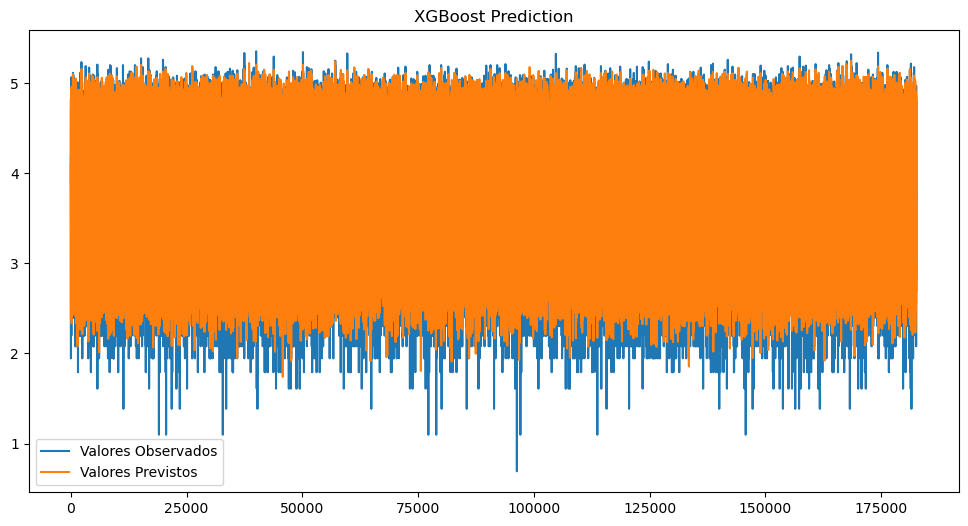

In [52]:
# Plot
fig = plt.figure(figsize = (12,6))
sales = plt.plot(y_teste.values, label = 'Valores Observados')
forecast = plt.plot(previsoes, label = 'Valores Previstos')
plt.legend(loc = 'best')
plt.title("XGBoost Prediction")

In [53]:
print('XGBoost MAE = ', mean_absolute_error(previsoes, y_teste.values))

XGBoost MAE =  0.1297934624504067


In [54]:
print('XGBoost MSE = ', mean_squared_error(previsoes, y_teste.values))

XGBoost MSE =  0.028951721629166222


# Fim